## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [61]:
import string
import os

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [62]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [63]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = ''.join(text).lower()

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Data loading: "Евгений Онегин"


In [64]:
!curl -L -o onegin.txt https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r', encoding='utf-8') as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t\t', '') for x in text]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  256k  100  256k    0     0   313k      0 --:--:-- --:--:-- --:--:--  314k


In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [65]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = ''.join(text).lower()


Put all the characters, that you've seen in the text, into variable `tokens`.

In [66]:
tokens = sorted(set(text))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [67]:
# dict <index>:<char>
# Your great code here
token_to_idx = {ch: idx for idx, ch in enumerate(tokens)}

# dict <char>:<index>
# Your great code here
idx_to_token = {idx: ch for idx, ch in enumerate(tokens)}

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [68]:
# Your code here
import torch
import torch.nn as nn


device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

torch.set_default_device(device)

class CharRNN(nn.Module):
    def __init__(self, num_tokens=len(tokens), emb_size=18, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, emb_size)
        self.rnn_update = nn.Linear(emb_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        self.dropout = nn.Dropout(0.1)

    def initial_state(self, batch_size):
        return torch.zeros(batch_size, self.num_units, device=device)

    def forward(self, x, h_prev):
        x_emb = self.embedding(x)
        x_and_h = torch.cat([x_emb, h_prev], dim=-1)
        h_next = self.rnn_update(x_and_h)
        h_next = torch.tanh(h_next)
        h_next = self.dropout(h_next)

        assert h_next.size() == h_prev.size()
        
        logits = self.rnn_to_logits(h_next)
        return logits, h_next

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [69]:
from torch.utils.data import Dataset, DataLoader

class CharDataset(Dataset):
    def __init__(self, encoded_text: torch.Tensor, seq_len=128, stride=128):
        self.data = encoded_text
        self.seq_len = seq_len
        self.stride = stride
        self.max_start = len(encoded_text) - (seq_len + 1)

    def __len__(self):
        return (self.max_start // self.stride) + 1

    def __getitem__(self, idx):
        start = idx * self.stride
        chunk = self.data[start : start + self.seq_len + 1]
        x = chunk[:-1]  
        y = chunk[1:]
        return x, y

seq_len = 128
encoded = torch.tensor([token_to_idx[ch] for ch in text], dtype=torch.long)
ds = CharDataset(encoded, seq_len=seq_len, stride=seq_len) 
loader = DataLoader(ds, batch_size=64, shuffle=True, drop_last=True)

x, y = next(iter(loader))
print(x.shape, y.shape) 

torch.Size([64, 128]) torch.Size([64, 128])


In [70]:
# Your plot code here
import torch.nn.functional as F


def nn_loop(char_rnn, batch_x):
    batch_size, seq_len = batch_x.shape
    hid_state = char_rnn.initial_state(batch_size)
    logits = []
    
    for t in range(seq_len):
        x_t = batch_x[:, t] 
        logit_t, hid_state = char_rnn(x_t, hid_state)
        logits.append(logit_t)
        
    return torch.stack(logits, dim=1)

num_tokens = len(tokens)
char_rnn = CharRNN(num_tokens, emb_size=64, rnn_num_units=256)
opt = torch.optim.Adam(char_rnn.parameters(), lr=1e-3)
loss_hist = []

for epoch in range(100):
    total = 0.0
    for x, y in loader:
        opt.zero_grad()
        logits = nn_loop(char_rnn, x)
        loss = F.cross_entropy(logits.reshape(-1, num_tokens), y.reshape(-1))

        loss.backward()
        opt.step()

        total += loss.item()

    avg_loss = total / len(loader)
    loss_hist.append(avg_loss)
    print(f"{(epoch+1):02d}: loss={(avg_loss):.4f}")




01: loss=3.6586
02: loss=3.0535
03: loss=2.8270
04: loss=2.6851
05: loss=2.5964
06: loss=2.5367
07: loss=2.4927
08: loss=2.4544
09: loss=2.4236
10: loss=2.3944
11: loss=2.3689
12: loss=2.3454
13: loss=2.3236
14: loss=2.3000
15: loss=2.2827
16: loss=2.2638
17: loss=2.2464
18: loss=2.2317
19: loss=2.2191
20: loss=2.2062
21: loss=2.1920
22: loss=2.1802
23: loss=2.1688
24: loss=2.1598
25: loss=2.1487
26: loss=2.1413
27: loss=2.1332
28: loss=2.1235
29: loss=2.1144
30: loss=2.1082
31: loss=2.1027
32: loss=2.0915
33: loss=2.0848
34: loss=2.0796
35: loss=2.0718
36: loss=2.0662
37: loss=2.0585
38: loss=2.0574
39: loss=2.0494
40: loss=2.0425
41: loss=2.0367
42: loss=2.0338
43: loss=2.0278
44: loss=2.0239
45: loss=2.0190
46: loss=2.0144
47: loss=2.0104
48: loss=2.0063
49: loss=1.9991
50: loss=1.9963
51: loss=1.9947
52: loss=1.9881
53: loss=1.9883
54: loss=1.9835
55: loss=1.9762
56: loss=1.9733
57: loss=1.9727
58: loss=1.9696
59: loss=1.9645
60: loss=1.9639
61: loss=1.9606
62: loss=1.9579
63: loss

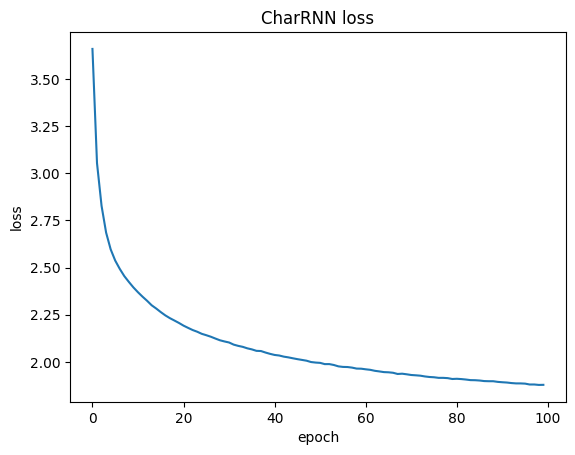

In [71]:
from matplotlib import pyplot as plt

def plot_history(hist, title=""):
    plt.plot(hist)
    plt.title(title + " loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")

plot_history(loss_hist, title="CharRNN")

In [72]:
import numpy as np
import torch
import torch.nn.functional as F

MAX_LENGTH = 1000

def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''

    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)  
    hid_state = char_rnn.initial_state(batch_size=1)            
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        # print(x_sequence[:, -1].shape, hid_state.shape)
        out, hid_state = char_rnn(x_sequence[:, i], hid_state)  # x_sequence[:, i] имеет shape [1] -> ок
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        out, hid_state = char_rnn(x_sequence[:, -1], hid_state)  # x_sequence[:, -1] имеет shape [1] -> ок
        # Be really careful here with the model output
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])


In [73]:
# An example of generated text.
print(generate_sample(char_rnn, "мой дядя", temperature=0.1))

мой дядят советельной
за мне под нею славы
простокать может был до жена
онегин по крастовый ленский,
нет привете сердце страсти,
и заботы не всё в семь он не волной
на своей сердце летя,
и долго в постором воле
с конец теперь на полет,
в семь подобно она забовь,
и все глядит него признать,
не может был недо молодной
под ней с ней одна своей молодной
просторой старины страстой,
не все света свой сердце в собраний
с горовить моей долодной
к молча в семья рокой,
свой старанный поле меня
в ней не всё подольстанит странной
как полетели в глушал
и в нем на поле привыт,
и в славый перед не мог без тременной
признала без устали до глядит,
и слез молчало на странный,
когда же мог и под ней на половой,
бездели в сердце ленский
в ней как так не вот она своей судьба свете
признать моей татьяна собой
не веселый сердце сводом
волны в нем она делать,
старины под без одно
и сердце подруга должной
он всех поле приветельной
он последно в том пестранный страство,
в головой сердце полна
и с ней на волен е

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [74]:
# Your beautiful code here

class CharLSTM(nn.Module):
    def __init__(self, num_tokens, emb_size=64, lstm_num_units=256):
        super().__init__()
        self.num_tokens = num_tokens
        self.num_units = lstm_num_units

        self.embedding = nn.Embedding(num_tokens, emb_size)
        self.cell = nn.LSTMCell(input_size=emb_size, hidden_size=lstm_num_units)
        self.to_logits = nn.Linear(lstm_num_units, num_tokens)

    def forward(self, x, state):
        h, c = state
        x_emb = self.embedding(x)   
        h, c = self.cell(x_emb, (h, c))     
        logits = self.to_logits(h)          
        return logits, (h, c)

    def initial_state(self, batch_size, device=None):
        h0 = torch.zeros(batch_size, self.num_units, device=device)
        c0 = torch.zeros(batch_size, self.num_units, device=device)
        return (h0, c0)

In [75]:
num_tokens = len(tokens)
char_lstm = CharLSTM(num_tokens, emb_size=64, lstm_num_units=256)
opt = torch.optim.Adam(char_lstm.parameters(), lr=1e-3)
loss_hist = []

for epoch in range(100):
    total = 0.0
    for x, y in loader:
        opt.zero_grad()
        logits = nn_loop(char_lstm, x)
        loss = F.cross_entropy(logits.reshape(-1, num_tokens), y.reshape(-1))

        loss.backward()
        opt.step()

        total += loss.item()

    avg_loss = total / len(loader)
    loss_hist.append(avg_loss)
    print(f"{(epoch+1):02d}: loss={(avg_loss):.4f}")

01: loss=3.7924
02: loss=3.2054
03: loss=2.9992
04: loss=2.8200
05: loss=2.6939
06: loss=2.6064
07: loss=2.5422
08: loss=2.4889
09: loss=2.4415
10: loss=2.4052
11: loss=2.3759
12: loss=2.3436
13: loss=2.3213
14: loss=2.3036
15: loss=2.2792
16: loss=2.2581
17: loss=2.2470
18: loss=2.2275
19: loss=2.2116
20: loss=2.1994
21: loss=2.1850
22: loss=2.1733
23: loss=2.1591
24: loss=2.1465
25: loss=2.1328
26: loss=2.1233
27: loss=2.1099
28: loss=2.0999
29: loss=2.0892
30: loss=2.0768
31: loss=2.0681
32: loss=2.0586
33: loss=2.0475
34: loss=2.0395
35: loss=2.0286
36: loss=2.0197
37: loss=2.0090
38: loss=1.9986
39: loss=1.9907
40: loss=1.9838
41: loss=1.9751
42: loss=1.9640
43: loss=1.9537
44: loss=1.9463
45: loss=1.9365
46: loss=1.9291
47: loss=1.9208
48: loss=1.9114
49: loss=1.9048
50: loss=1.8984
51: loss=1.8887
52: loss=1.8808
53: loss=1.8698
54: loss=1.8642
55: loss=1.8561
56: loss=1.8502
57: loss=1.8422
58: loss=1.8355
59: loss=1.8265
60: loss=1.8184
61: loss=1.8138
62: loss=1.8071
63: loss

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [84]:
# Text generation with different temperature values here
for t in [0.1, 0.5, 1.0, 2.0]:
    print("temperature =", t)
    print(">>>>>>>>>>>>>>>")
    print(generate_sample(char_lstm, "мой дядя", temperature=t, max_length=250))
    print("<<<<<<<<<<<<<<<")

temperature = 0.1
>>>>>>>>>>>>>>>
мой дядя страстей не странный,
и в сердце постели страстной
и таня в ней разговор и труд
она старины страстей волненье,
в сердце пред нею старины,
и в сердце постели страстной
в том с ней старины страстей надежды,
под ней долго с ним под ней дом
и в 
<<<<<<<<<<<<<<<
temperature = 0.5
>>>>>>>>>>>>>>>
мой дядя смелеть не раздом,
иль не с частой не молчались,
и сердце по могали он.



xxiii

и в тот бедно романа страда,
как вам обще лиценный свет…
так в доскуги моей рукой,
и миль мой был и зевы откры,
в предметный далько в полей;
он своим сладкой о
<<<<<<<<<<<<<<<
temperature = 1.0
>>>>>>>>>>>>>>>
мой дядя младое тину,
спись бедник мы хотьме проверка
ирего нучеще соседкой,
коненно толкному по сменя
свобольно? суек, в всех мирал;
вохвать негод инениешно.
она глубуя, как считате)?
носня было грядит одни.
оно пред може свобозяю,
поклонник облюбин
<<<<<<<<<<<<<<<
temperature = 2.0
>>>>>>>>>>>>>>>
мой дядя…». твпяти, в у:
насхал, од младовлыхатье),;
и луrыvы н

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [86]:
# Saving and loading code here
torch.save({
    "model_state": char_lstm.state_dict(),
    "num_tokens": len(tokens),
    "tokens": tokens,
    "emb_size": 64,
    "lstm_num_units": 256
}, "char_lstm_onegin.pth")

inst = torch.load("char_lstm_onegin.pth", map_location="cpu")

lstm2 = CharLSTM(
    num_tokens=inst["num_tokens"],
    emb_size=inst["emb_size"],
    lstm_num_units=inst["lstm_num_units"]
)
lstm2.load_state_dict(inst["model_state"])
lstm2.eval()

print(generate_sample(lstm2, seed_phrase="мой дядя ", max_length=300, temperature=0.7))

мой дядя извали,
и в сердце тревить и вольна.



xxiii

нежала, друг невинных очи,
причешать татьяна страсти,
когда ясно и руках оне.



xii

как наши блаженствит услаженьем
володный на повести грустной,
ни колку трупа высет ей.



xxxvi

просчет, ком поклины странены;
то не госток на отселет,
и в м


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)